# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 120 ms, sys: 99.3 ms, total: 219 ms
Wall time: 218 ms


Choose number of events to be analysed

In [24]:
run = 'final_fullgraph'

nevents = raw.index.max()
nevents = 1000
node_dim = 2
edge_dim = 2

# Investigate raw data

<Figure size 576x432 with 0 Axes>

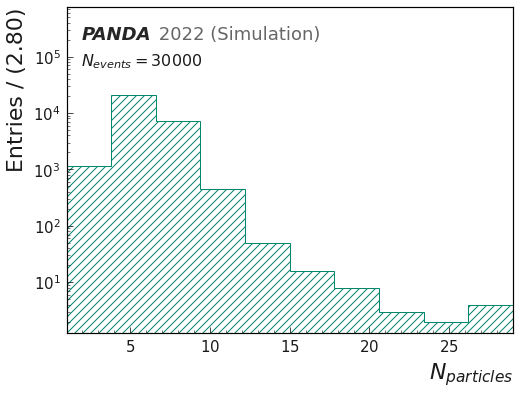

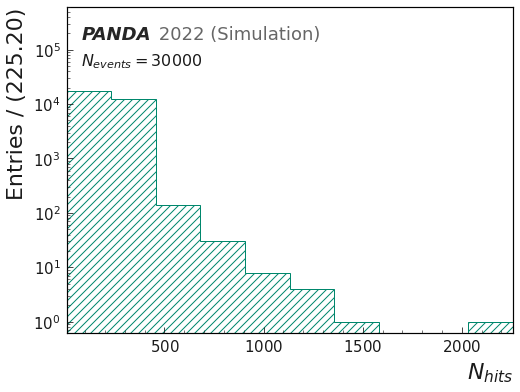

mean number of particles: 5.81, mean number of hits: 220.65


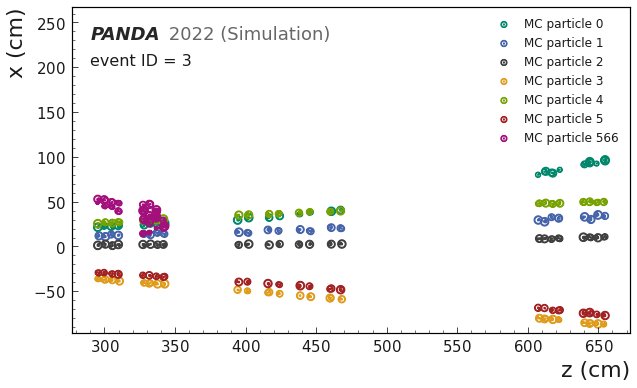

number of no-curlers: 161388, number of curlers: 12811, proportion of curlers: 0.07938012739484968


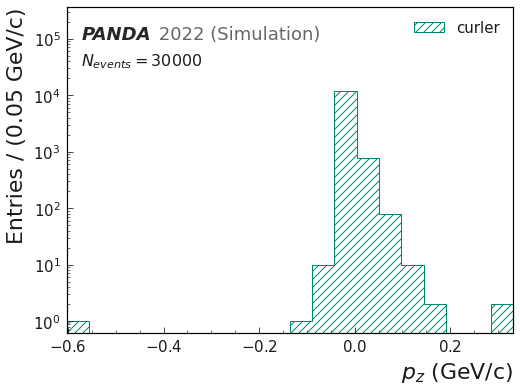

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78it/s]


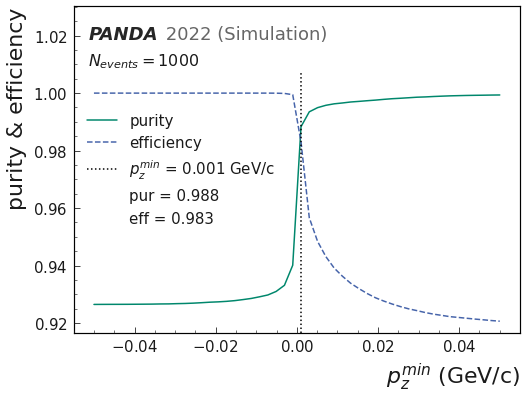

best pz threshold at 0.0010, removed bad (TNR): 0.854, lost good (FNR): 0.017
CPU times: user 35.4 s, sys: 7.2 s, total: 42.6 s
Wall time: 40.5 s


In [4]:
%%time

show=True
if show:
   
    plot_information(raw, name=run, nevents=30000).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8, name=run).plot_eventdisplay()
    
    data_eval = evaluate_data(raw, ncuts=50, nevents=30000, name=run)
    data_eval.curler_dist()

    purity, efficiency, cuts, cutPos, TNR, FNR = data_eval.find_pzcut()
    data = plot_information(name=run, nevents=nevents)
    data.plot_purity_efficiency(
        cuts, 
        25, 
        purity, 
        efficiency, 
        TNR, 
        FNR, 
        nevents, 
        variable = r'$p_z^{min}$', 
        unit= 'GeV/c',
        xname = r'$p_z^{min}$ (GeV/c)', 
        yname = 'purity & efficiency', 
        save_name = f'img/3_pz_threshold_{run}.pdf')

# Graph building for training

In [5]:
in_dir = 'data/graphs'

pz_min = 0.001
slope_max = 1.
minlayer=0
maxlayer=24

graph_dir = f'{in_dir}_{run}_pzmin_{pz_min}_slopemax_{slope_max}'

In [25]:
%%time

data = build_graphs(raw,end=30000, shuffle=True,  pz_min=pz_min, remove_duplicates=True, slope=slope_max, graph_dir=graph_dir)
create_g = False

if create_g:
    graphs = data.create_graph_list(node_dim=node_dim, edge_dim=edge_dim, minlayer=minlayer, maxlayer=maxlayer)
    print(f'graphs saved to {graph_dir}')

    Nedges, Ntrue = 0,0     
    for g in graphs:
        Nedges += len(g.y)
        Ntrue += sum(g.y)
    print(f'Nedges: {Nedges}, Ntrue: {Ntrue}, Ntrue/Nedges: {Ntrue/Nedges}, meanNedges: {Nedges/nevents}')
    
else:
    graphs = load_graphs(graph_dir, n_graphs=nevents, node_dim=node_dim, edge_dim=edge_dim) #load n random sample graphs

#show preprocessed data
data.events.sort_index()

Nedges: 161324, Ntrue: 96416, Ntrue/Nedges: 0.5976544097592422
CPU times: user 2.49 s, sys: 1.53 s, total: 4.02 s
Wall time: 4.15 s


,hit_id,particle_id,x,z,iso,pz,chamber_id,skewed,layer_id,layer,Hit_id
event_id,,,,,,,,,,,
0,547,2,29.542500,309.390015,0.380595,7.657896,1,0,7,3,106
0,20378,2,71.457497,654.364685,0.103020,7.614486,6,0,48,24,148
0,727353,0,27.522499,437.489990,0.119575,2.421842,4,0,25,13,221
0,1283618,3,-32.067501,653.489990,0.158261,7.700203,6,0,47,23,99
0,1944183,0,18.937500,327.769684,0.309845,2.432236,2,0,10,6,206
...,...,...,...,...,...,...,...,...,...,...,...
29999,933381,3,5.807500,423.839691,0.037754,5.498756,3,0,24,12,120
29999,623789,0,5.302500,653.489990,0.086463,7.105002,6,0,47,23,239
29999,1988600,5,7.827500,342.264679,0.104802,1.379045,2,0,16,8,15


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7019.25it/s]


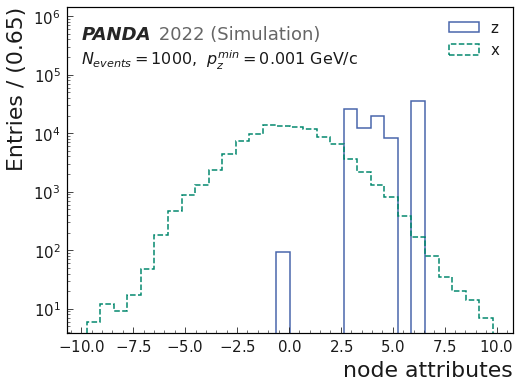

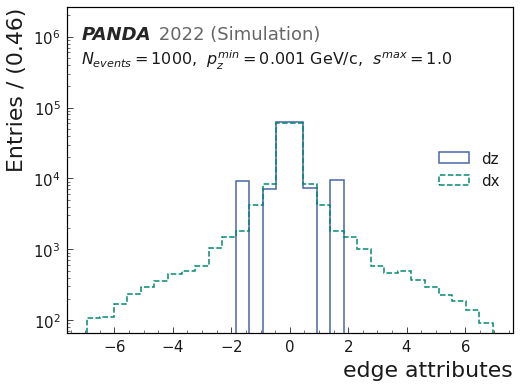

In [7]:
test_samples = 1000
show_graph_dims = True

if show_graph_dims:
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run)
    show_infos.plot_graph_data_info(bins=30, log=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:49<00:00,  6.50s/it]


average number of nodes: 102.83 with standard deviation 23.89


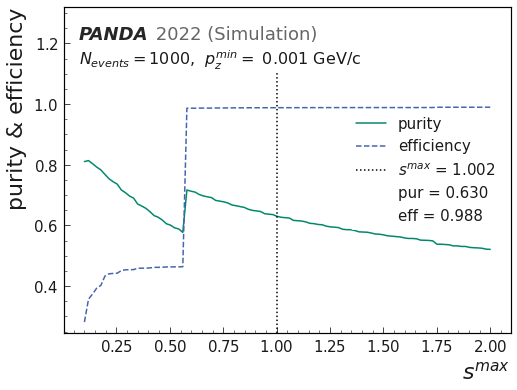

best pz threshold at 1.0020, removed bad (TNR): 0.988, lost good (FNR): 0.012


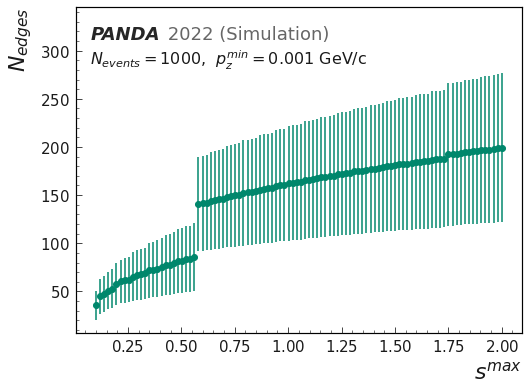

CPU times: user 10min 47s, sys: 3.34 s, total: 10min 51s
Wall time: 10min 50s


In [8]:
%%time
evaluate_gb = True
test_samples = 1000
ncuts = 100

if evaluate_gb:
        
    testdata = build_graphs(raw,end=test_samples, shuffle=True, pz_min=pz_min, remove_duplicates=True, slope=slope_max)
    slope = np.linspace(0.1,2,ncuts)
    purities, efficiencies, TNRs, FNRs = np.zeros((4,ncuts))
    nnodes, nedges = [], []
           
    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False, node_dim=2, edge_dim=2, minlayer=minlayer, maxlayer=maxlayer)
        purity, efficiency, TNR, FNR, _ = evaluate_graphs(testdata.events, testgraphs, name=run).evaluate_graphs(show_progress=False)
        purities[i] = purity
        efficiencies[i] = efficiency
        TNRs[i] = TNR
        FNRs[i] = FNR
        
        ne = []
        
        for g in testgraphs:
            ne.append(len(g.y))
        nedges.append([np.mean(ne), np.std(ne)])
    nn = []
    for g in testgraphs:
        nn.append(len(g.x))
    nnodes = [np.mean(nn), np.std(nn)]
    print(f'average number of nodes: {nnodes[0]:.2f} with standard deviation {nnodes[1]:.2f}')
    nedges = np.array(nedges)
        
                
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run)
    cutPos = np.argmin(np.abs(np.array(purities)-np.array(efficiencies)))
    cutPos = 47

    show_infos.plot_purity_efficiency(
        cuts=slope, 
        cut_pos=cutPos, 
        purity=purities, 
        efficiency=efficiencies, 
        TNR=TNRs, 
        FNR=FNRs, 
        nevents=test_samples, 
        variable=r'$s^{max}$',
        xname=r'$s^{max}$', 
        yname='purity & efficiency', 
        save_name=f'img/3_graphbuilding_purity_efficiency_{run}.pdf', 
        add_inf=r',  $p_z^{min} =$ '+f'{pz_min:.3f} GeV/c',
        legloc='center right', 
        scale=1.38)
        
    
    show_infos.plot_graph_dimensions(nnodes, nedges, slope, test_samples)

# Plot Graphs

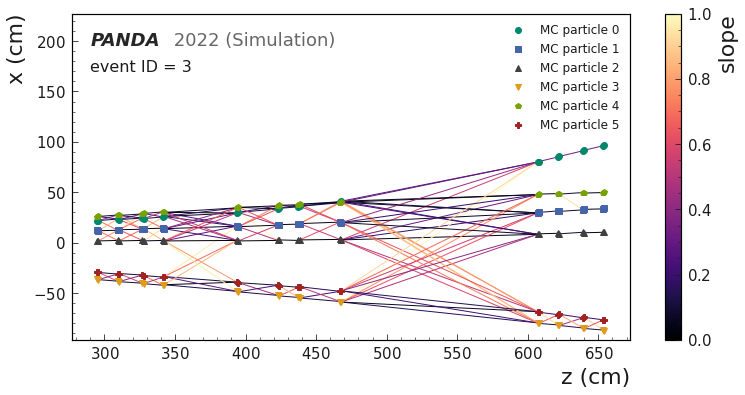

CPU times: user 1.08 s, sys: 116 ms, total: 1.2 s
Wall time: 1.05 s


In [23]:
%%time
# evID = np.random.randint(nevents)
evID = 3
plot_graphs=True
    
if plot_graphs:    

    hits = data.events.loc[evID]
    graph = graphs[evID]

    plotevent = plot_event(hits, graph=graph, shift=.14, scale=1.6, name=run)
    # plotevent.plot_eventdisplay()
    plotevent.plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=True, colormap='magma', reverse_cm=False)


# Prepare Training

In [10]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 8
lr = 0.01
gamma = 0.7
epochs = 40
patience = 10
step_size = 8

name = f'IN_nevents_{nevents}_hidden_{hidden_size}_lr_{lr}_gamma_{gamma}_steps_{step_size}'


In [11]:
batch_size = 1
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 16}

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [12]:
model = InteractionNetwork(node_dim, edge_dim, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 2, edge_dim: 2, hidden_size: 8)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     48     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     16     |
|  R1.layers.4.bias  |     2      |
| O.layers.0.weight  |     32     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     16     |
|  O.layers.4.bias   |     2      |
| R2.layers.0.weight |     48     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 413


# Training

In [13]:
results = train_model(
    train_loader, 
    val_loader, 
    model, 
    optimizer, 
    scheduler, 
    device=device,
    epochs=epochs, 
    patience=patience, 
    run=run,
    name=name
)


  0%|                                                                                                            | 0/40 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 4.91s
Mean Train Batch Loss: 0.3251


  2%|██▌                                                                                                 | 1/40 [00:05<03:44,  5.76s/it]


 Validation set: Average loss: 0.2451
, Accuracy: 0.9055

Validation loss decreased (inf --> 0.245081).  Saving model ...
Train Epoch: 2, epoch time: 4.96s
Mean Train Batch Loss: 0.2280


  5%|█████                                                                                               | 2/40 [00:11<03:40,  5.81s/it]


 Validation set: Average loss: 0.2170
, Accuracy: 0.9118

Validation loss decreased (0.245081 --> 0.216963).  Saving model ...
Train Epoch: 3, epoch time: 4.94s
Mean Train Batch Loss: 0.2022


  8%|███████▌                                                                                            | 3/40 [00:17<03:34,  5.79s/it]


 Validation set: Average loss: 0.2048
, Accuracy: 0.9209

Validation loss decreased (0.216963 --> 0.204800).  Saving model ...
Train Epoch: 4, epoch time: 4.85s
Mean Train Batch Loss: 0.1984


 10%|██████████                                                                                          | 4/40 [00:23<03:26,  5.74s/it]


 Validation set: Average loss: 0.1938
, Accuracy: 0.9221

Validation loss decreased (0.204800 --> 0.193821).  Saving model ...
Train Epoch: 5, epoch time: 4.89s
Mean Train Batch Loss: 0.1960


 12%|████████████▌                                                                                       | 5/40 [00:28<03:20,  5.74s/it]


 Validation set: Average loss: 0.1987
, Accuracy: 0.9181

EarlyStopping counter: 1 out of 10
Train Epoch: 6, epoch time: 4.82s
Mean Train Batch Loss: 0.1936


 15%|███████████████                                                                                     | 6/40 [00:34<03:14,  5.72s/it]


 Validation set: Average loss: 0.1976
, Accuracy: 0.9193

EarlyStopping counter: 2 out of 10
Train Epoch: 7, epoch time: 4.81s
Mean Train Batch Loss: 0.1938


 18%|█████████████████▌                                                                                  | 7/40 [00:40<03:07,  5.69s/it]


 Validation set: Average loss: 0.2049
, Accuracy: 0.9194

EarlyStopping counter: 3 out of 10
Train Epoch: 8, epoch time: 5.00s
Mean Train Batch Loss: 0.1920


 20%|████████████████████                                                                                | 8/40 [00:45<03:03,  5.74s/it]


 Validation set: Average loss: 0.1855
, Accuracy: 0.9244

Validation loss decreased (0.193821 --> 0.185474).  Saving model ...
Train Epoch: 9, epoch time: 4.91s
Mean Train Batch Loss: 0.1831


 22%|██████████████████████▌                                                                             | 9/40 [00:51<02:58,  5.76s/it]


 Validation set: Average loss: 0.1814
, Accuracy: 0.9261

Validation loss decreased (0.185474 --> 0.181412).  Saving model ...
Train Epoch: 10, epoch time: 4.68s
Mean Train Batch Loss: 0.1844


 25%|████████████████████████▊                                                                          | 10/40 [00:57<02:50,  5.69s/it]


 Validation set: Average loss: 0.1837
, Accuracy: 0.9245

EarlyStopping counter: 1 out of 10
Train Epoch: 11, epoch time: 4.82s
Mean Train Batch Loss: 0.1819


 28%|███████████████████████████▏                                                                       | 11/40 [01:02<02:44,  5.68s/it]


 Validation set: Average loss: 0.1891
, Accuracy: 0.9215

EarlyStopping counter: 2 out of 10
Train Epoch: 12, epoch time: 4.88s
Mean Train Batch Loss: 0.1826


 30%|█████████████████████████████▋                                                                     | 12/40 [01:08<02:39,  5.69s/it]


 Validation set: Average loss: 0.1938
, Accuracy: 0.9192

EarlyStopping counter: 3 out of 10
Train Epoch: 13, epoch time: 4.96s
Mean Train Batch Loss: 0.1828


 32%|████████████████████████████████▏                                                                  | 13/40 [01:14<02:34,  5.73s/it]


 Validation set: Average loss: 0.1900
, Accuracy: 0.9216

EarlyStopping counter: 4 out of 10
Train Epoch: 14, epoch time: 4.81s
Mean Train Batch Loss: 0.1821


 35%|██████████████████████████████████▋                                                                | 14/40 [01:20<02:28,  5.72s/it]


 Validation set: Average loss: 0.1920
, Accuracy: 0.9229

EarlyStopping counter: 5 out of 10
Train Epoch: 15, epoch time: 4.81s
Mean Train Batch Loss: 0.1807


 38%|█████████████████████████████████████▏                                                             | 15/40 [01:25<02:22,  5.70s/it]


 Validation set: Average loss: 0.1800
, Accuracy: 0.9229

Validation loss decreased (0.181412 --> 0.180038).  Saving model ...
Train Epoch: 16, epoch time: 4.87s
Mean Train Batch Loss: 0.1810


 40%|███████████████████████████████████████▌                                                           | 16/40 [01:31<02:17,  5.72s/it]


 Validation set: Average loss: 0.1803
, Accuracy: 0.9254

EarlyStopping counter: 1 out of 10
Train Epoch: 17, epoch time: 4.77s
Mean Train Batch Loss: 0.1766


 42%|██████████████████████████████████████████                                                         | 17/40 [01:37<02:10,  5.69s/it]


 Validation set: Average loss: 0.1889
, Accuracy: 0.9250

EarlyStopping counter: 2 out of 10
Train Epoch: 18, epoch time: 4.83s
Mean Train Batch Loss: 0.1764


 45%|████████████████████████████████████████████▌                                                      | 18/40 [01:42<02:05,  5.68s/it]


 Validation set: Average loss: 0.1768
, Accuracy: 0.9258

Validation loss decreased (0.180038 --> 0.176840).  Saving model ...
Train Epoch: 19, epoch time: 4.71s
Mean Train Batch Loss: 0.1753


 48%|███████████████████████████████████████████████                                                    | 19/40 [01:48<01:58,  5.65s/it]


 Validation set: Average loss: 0.1778
, Accuracy: 0.9268

EarlyStopping counter: 1 out of 10
Train Epoch: 20, epoch time: 4.87s
Mean Train Batch Loss: 0.1759


 50%|█████████████████████████████████████████████████▌                                                 | 20/40 [01:54<01:53,  5.67s/it]


 Validation set: Average loss: 0.1781
, Accuracy: 0.9253

EarlyStopping counter: 2 out of 10
Train Epoch: 21, epoch time: 4.95s
Mean Train Batch Loss: 0.1753


 52%|███████████████████████████████████████████████████▉                                               | 21/40 [01:59<01:48,  5.72s/it]


 Validation set: Average loss: 0.1766
, Accuracy: 0.9264

Validation loss decreased (0.176840 --> 0.176642).  Saving model ...
Train Epoch: 22, epoch time: 5.18s
Mean Train Batch Loss: 0.1752


 55%|██████████████████████████████████████████████████████▍                                            | 22/40 [02:06<01:44,  5.82s/it]


 Validation set: Average loss: 0.1742
, Accuracy: 0.9273

Validation loss decreased (0.176642 --> 0.174172).  Saving model ...
Train Epoch: 23, epoch time: 4.98s
Mean Train Batch Loss: 0.1749


 57%|████████████████████████████████████████████████████████▉                                          | 23/40 [02:11<01:39,  5.83s/it]


 Validation set: Average loss: 0.1878
, Accuracy: 0.9252

EarlyStopping counter: 1 out of 10
Train Epoch: 24, epoch time: 4.82s
Mean Train Batch Loss: 0.1749


 60%|███████████████████████████████████████████████████████████▍                                       | 24/40 [02:17<01:32,  5.78s/it]


 Validation set: Average loss: 0.1774
, Accuracy: 0.9273

EarlyStopping counter: 2 out of 10
Train Epoch: 25, epoch time: 5.01s
Mean Train Batch Loss: 0.1726


 62%|█████████████████████████████████████████████████████████████▉                                     | 25/40 [02:23<01:26,  5.79s/it]


 Validation set: Average loss: 0.1778
, Accuracy: 0.9267

EarlyStopping counter: 3 out of 10
Train Epoch: 26, epoch time: 4.93s
Mean Train Batch Loss: 0.1724


 65%|████████████████████████████████████████████████████████████████▎                                  | 26/40 [02:29<01:21,  5.80s/it]


 Validation set: Average loss: 0.1858
, Accuracy: 0.9242

EarlyStopping counter: 4 out of 10
Train Epoch: 27, epoch time: 4.77s
Mean Train Batch Loss: 0.1716


 68%|██████████████████████████████████████████████████████████████████▊                                | 27/40 [02:34<01:14,  5.75s/it]


 Validation set: Average loss: 0.1728
, Accuracy: 0.9285

Validation loss decreased (0.174172 --> 0.172839).  Saving model ...
Train Epoch: 28, epoch time: 4.92s
Mean Train Batch Loss: 0.1718


 70%|█████████████████████████████████████████████████████████████████████▎                             | 28/40 [02:40<01:09,  5.75s/it]


 Validation set: Average loss: 0.1757
, Accuracy: 0.9254

EarlyStopping counter: 1 out of 10
Train Epoch: 29, epoch time: 4.82s
Mean Train Batch Loss: 0.1712


 72%|███████████████████████████████████████████████████████████████████████▊                           | 29/40 [02:46<01:03,  5.73s/it]


 Validation set: Average loss: 0.1761
, Accuracy: 0.9281

EarlyStopping counter: 2 out of 10
Train Epoch: 30, epoch time: 4.84s
Mean Train Batch Loss: 0.1707


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 30/40 [02:52<00:57,  5.75s/it]


 Validation set: Average loss: 0.1733
, Accuracy: 0.9270

EarlyStopping counter: 3 out of 10
Train Epoch: 31, epoch time: 4.80s
Mean Train Batch Loss: 0.1710


 78%|████████████████████████████████████████████████████████████████████████████▋                      | 31/40 [02:57<00:51,  5.72s/it]


 Validation set: Average loss: 0.1811
, Accuracy: 0.9259

EarlyStopping counter: 4 out of 10
Train Epoch: 32, epoch time: 4.81s
Mean Train Batch Loss: 0.1712


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 32/40 [03:03<00:45,  5.71s/it]


 Validation set: Average loss: 0.1781
, Accuracy: 0.9259

EarlyStopping counter: 5 out of 10
Train Epoch: 33, epoch time: 4.93s
Mean Train Batch Loss: 0.1693


 82%|█████████████████████████████████████████████████████████████████████████████████▋                 | 33/40 [03:09<00:40,  5.73s/it]


 Validation set: Average loss: 0.1730
, Accuracy: 0.9280

EarlyStopping counter: 6 out of 10
Train Epoch: 34, epoch time: 4.98s
Mean Train Batch Loss: 0.1696


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 34/40 [03:15<00:34,  5.76s/it]


 Validation set: Average loss: 0.1739
, Accuracy: 0.9274

EarlyStopping counter: 7 out of 10
Train Epoch: 35, epoch time: 4.89s
Mean Train Batch Loss: 0.1693


 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 35/40 [03:20<00:28,  5.76s/it]


 Validation set: Average loss: 0.1745
, Accuracy: 0.9265

EarlyStopping counter: 8 out of 10
Train Epoch: 36, epoch time: 4.89s
Mean Train Batch Loss: 0.1681


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 36/40 [03:26<00:23,  5.75s/it]


 Validation set: Average loss: 0.1743
, Accuracy: 0.9283

EarlyStopping counter: 9 out of 10
Train Epoch: 37, epoch time: 4.80s
Mean Train Batch Loss: 0.1685


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 36/40 [03:32<00:23,  5.89s/it]


 Validation set: Average loss: 0.1733
, Accuracy: 0.9280

EarlyStopping counter: 10 out of 10
Early stopping


# Evaluate Training

In [14]:
# output_name = 'train_IN_1000_8_0.004997234020786113_0.9853401378434626_8.npy'
# train_output_dir = 'train_output'

# train_output = np.load(os.path.join(train_output_dir, output_name), allow_pickle=True).item()
# model = torch.load('models/best_model_nevents_1000_hidden_dim_8.pt')

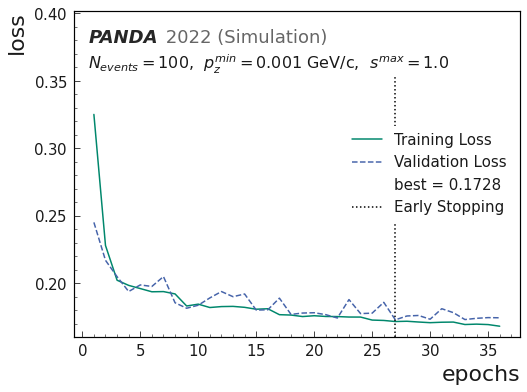

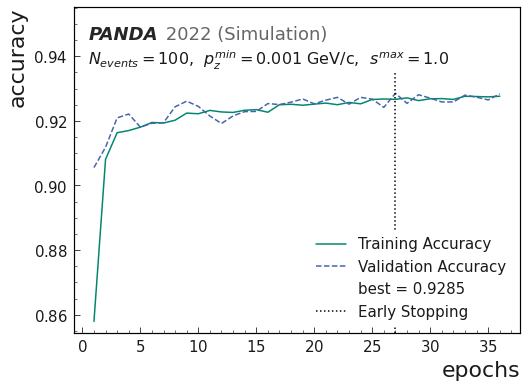

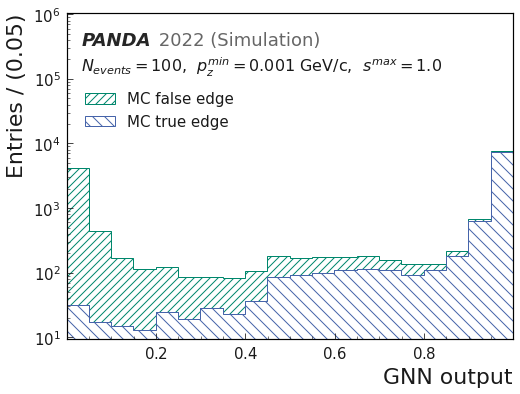

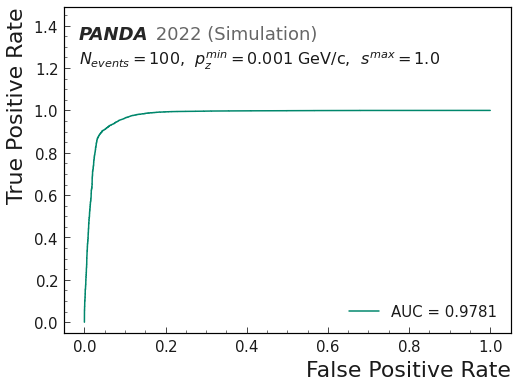

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 16617.69it/s]


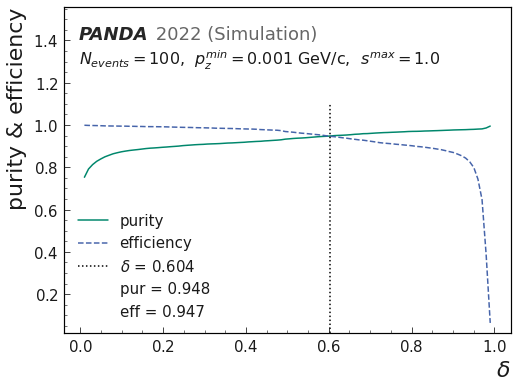

best $\delta$ threshold at 0.6039, removed bad (TNR): 0.919, lost good (FNR): 0.053


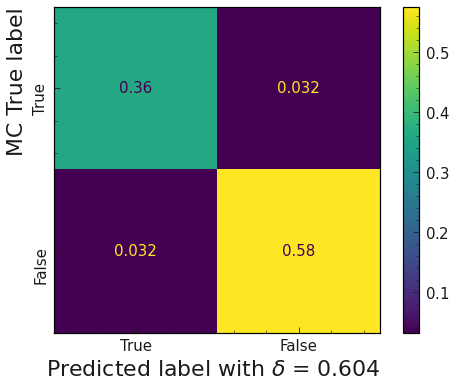

In [15]:
model, train_output = results.trained

threshold = 0.7
evaluation = evaluate_model(model, test_loader, pz_min, slope_max, train_output, threshold, ncuts=100, name=run)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics(output_bins=20, scale=1.5)

# Show Results

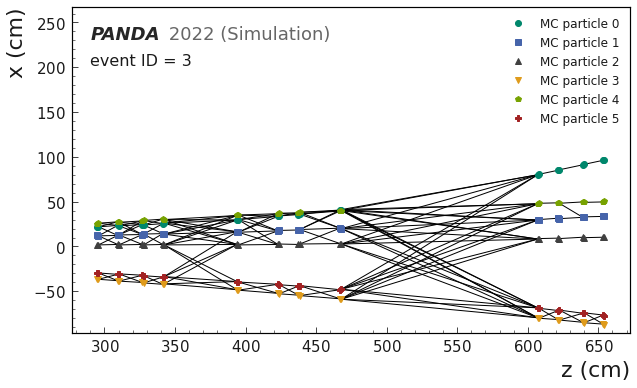

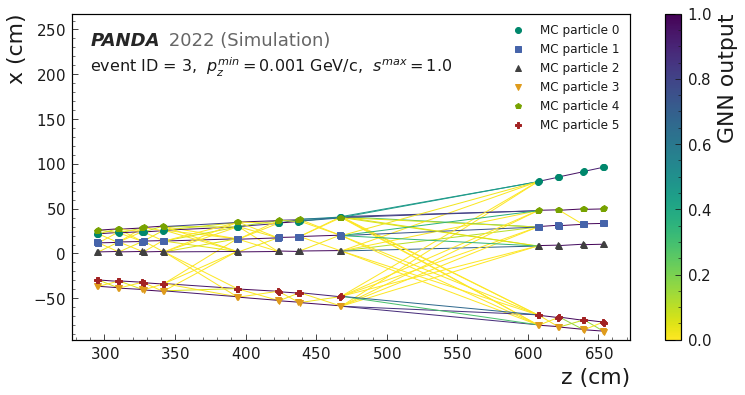

In [22]:
plot_event(hits, graph, scale=1.8, name=run+'_black').plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=False)
plot_event(hits, graph, name=run, scale=1.8).plot_traineddisplay(model, pz_min=pz_min, slope_max=slope_max)


In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

outputs, targets, zs = [], [], []

for d in tqdm(data):
    output = model(d).squeeze(1).detach().numpy()
    y = d.y.detach().numpy()
    
    outputs = np.append(outputs, output)
    targets = np.append(targets, y) 
    zs = np.append(zs, np.abs(d.edge_attr[:,1].detach().numpy())*100)
    
thld = 0.8
outputs[outputs > thld] = 1.
outputs[outputs < thld] = 0.

equal = np.equal(outputs, targets)
arr = np.stack((equal,zs), axis=1)
bins = np.unique(arr[:,1])
inds = np.digitize(arr[:,1], bins)

test = np.zeros((len(bins),3))

for i, b in enumerate(bins):
    arr_binned = arr[inds==i+1][:,0]
    test[i] = [b, np.mean(arr_binned), np.std(arr_binned)]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 189.62it/s]


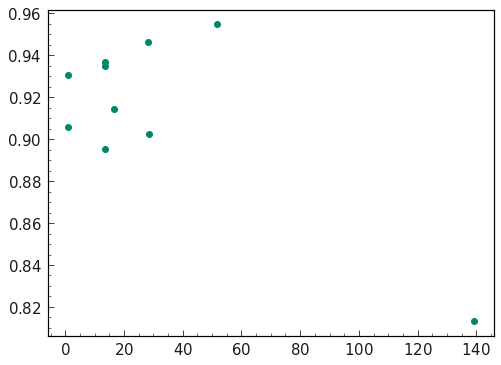

In [19]:
plt.plot(test[:,0], test[:,1], 'o')